In [0]:
import operator
import numpy as np
import numpy_financial as npf
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Scenario
Many in industry have taken the leap from on premise to cloud based infrastructure. In the following scenario, we will examine this real world problem using Monte Carlo simulation for standard line items of an on premise to cloud migration. For you inidividual case, you may have other cost to consider as well. For the cloud provider, we are using Google and Databricks for analytics platform. Here I have rolled up their cost into one line item but you may want to break them out for a more robust analysis. Additionally, Databricks provided the numbers below for this scenario. Many thanks to them.

In the case laid out below, we have that
1. `data_center_thb` is the cost data center per year in Thai Baht.
2. `servers` are the number of servers we maintain.
3. `software` is the cost of enterprise licenses we pay for.
4. `engineers_thb` is the cost of all our engineers who would have responsibilities covered by migrating cloud.
5. `pro_service` is the professional service fee from GCP and Databricks for transitioning from on premise to cloud.
6. `hurdle_rate` is the business risk of capital rate; however, we can use a distribution for this value to look different rates.

This notebook can be modified for traditional applications such as manufactoring or other tech style evaluations. This isn't solely for analyzing on premise to cloud but just the example used here today.

### Info
In this scenario, we are based in Thailand so local cost will be in THB and others will be USD. All THB cost will be indicated with THB, and during the analysis, we will convert to USD for the final results.

In [0]:
data_center_thb = 33000000      # 500k-1.3M USD; we will take 1M USD
infra_per_server_thb = 1163250  # 1.41M annual per server would 1.16M THB
servers = 200
software = 468000
engineers_thb = 2227500 * 7     # 7 engineers at ~2.2M THB a year; full time for cloud replaceable costs
tax_rate = .2                   # corporate tax rate incurred on all positive revenues
hurdle_rate = .1                # risk adjusted hurdle rate can compute by using the function below instead of this static value
year_one_thb = 33               # THB for year one (known)
# working with your vendors, you should be profile your current usage
pro_service = -350000           # migration professional service fee
platform = -944000              # contract rate for 5 years based on 4.635PB 4.72M but credits would probably be 4.85M
vm = -601000
storage = -875000

## Standard Distributions
Common distributions to use during capital budgeting Monte Carlo are `triangular`, `uniform`, and `normal`. However, others may be used with care. If one uses a normal distribution, remember the tails trail off to negative and positive infinity which may or may not make sense for your scenario. Even though the probability may be small of selection beyond 3 standard deviations, it can happen in large number of simulations. With normal distributions, it might be good to define lower and upper bounds to assign to anything selected beyond a certain range. Another option is to use distributions that have support and only needing to bound at one extreme.

In the distributions below, I demonstrate the use of `uniform`, `triangular`, and `normal`, but dont feel limited to these. If you know one of your cost has a `beta` distribution, use it. If you are a US user with US cost, you will not need the exchange rate throughout the this demo. You can either remove it or set it to 1 since dividing by will not change the end result.

In [0]:
def hardware_thb():
    """
    Cost of the hardware per server in THB.
    """
    return np.random.uniform(900000, 1200000)
  
  
def data_growth():
  """
  Data growth of the cluster.
  """
  return np.random.triangular(1.03, 1.075, 1.1)


def software_increase():
    """
    Percentage increase of software licenses yearly.
    """
    return np.random.triangular(1.005, 1.025, 1.05)


def engineers_increase():
    """
    Percentage increase of the salary of the engineers per year.
    """
    return np.random.triangular(1.05, 1.085, 1.12)


def data_center_cost_increase():
    """
    Data center shared space cost increase yearly.
    """
    return np.random.triangular(1.005, 1.01, 1.035)


def exchange_thb():
    """
    THB to USD exchange rate flucuation with a mean of 32 and SD of 2. In this case, we will bound the return
    values to a minimum of 28 and a maximum of 38.
    """
    thb = np.random.normal(32, 2)
    if thb < 28:
      return 30
    if thb > 36:
      return 36
    return thb


def year_one_dual_cost():
    """
    During the first year transition phase, we will experience partial on premise and cloud cost depending
    on the speed of migration.
    """
    return np.random.triangular(.25, .35, .5)
  
  
def platform_5year_contract_growth():
    """
    The growth rate for the contract platform cost.
    """
    return np.random.triangular(1.035, 1.05, 1.07)
  
  
def platform_vms_growth():
    """
    Platform cost and vms cost dont increase 1:1 with an increase in data. 
    Estimates according to DB was between 25-50%.
    """
    return np.random.triangular(0.25, 0.375, 0.5)
  
  
def risk_adjusted_hurdle():
  """
  We cannot account for every risk profile in this simulation; therefore, we can capture some of this additional
  risk by considering hurdle rate which incorporates a higher return needed.
  """
  rate = np.random.normal(.1, .025)  # mean 10% std 2.5%
  # will take a normal distribution with hard cuts at 10% and 25% as opposed to a triangular
  if rate < .1:
    return .1
  if rate > .25:
    return .25
  return rate

In [0]:
def create_data():
    # if you have more line items to account for, update the indices needed here.
    # setup dataframe
    df = pd.DataFrame([], columns=[f"year_{i}" for i in range(0, 11)])
    df.loc[:, "index"] = ["data_center", "infrastructure", "engineers", "software", "platform", "cloud_vms", "cloud_storage", "cashflows", "after_tax"]
    df.set_index("index", inplace=True)
    df.fillna(0, inplace=True)
    # initialize year_0
    df.loc["cashflows", "year_0"] = pro_service
    df.loc["after_tax", "year_0"] = pro_service
    
    # cloud/prem
    premise = ["data_center", "infrastructure", "engineers", "software"]
    cloud = ["platform", "cloud_vms", "cloud_storage"]
    platform = -944000 
    
    # this the spend for 5 years
    # if data growth causes higher spend, we need to add that in if it occurs.
    track_platform = 4850000

    for i in range(1, 11):
        # not the cleanest but just doing first year value setting and checking for cycle update params
        if i == 1:                            
            hardware = infra_per_server_thb / year_one_thb / 5 * servers 
            engineer_pay = engineers_thb / year_one_thb
            # to demo the split example, I am using 0.5 hardcode but you can use the distribution sampling.
            # dual_cost = year_one_dual_cost() 
            dual_cost = 0.5  # using 0.5 here to mimic the example online
            track_platform += platform
        elif i == 2:
            # distribution selection starts here; year one is known
            growth = data_growth()
            growth_others = 1 + (growth - 1) * platform_vms_growth()
            track_platform += platform * growth_others
            # we have -994k per year up to 4.85M. if our data growth increases platform cost beyond our contract
            # we would need to cover. baring no typos, this should do it but it doesn't happen in this example.
            platform = -944000 if track_platform >= 0 else -944000 + (platform * growth_others + 944000)
            engineer_pay = engineers_thb * engineers_increase() / exchange_thb()
        elif i == 6:
            # hardware upgrade cycle split cost over 5 years
            # platform contract renewal
            rate = exchange_thb()
            engineer_pay = engineers_thb * engineers_increase() / rate
            hardware = hardware_thb() / rate / 5 * servers    
            data_increase = data_growth()
            # contract
            platform = -944000 * platform_5year_contract_growth()
            track_platform = -platform * 5
        else:
            growth = data_growth()
            growth_others = 1 + (growth - 1) * platform_vms_growth()
            track_platform += platform * growth_others
            platform = platform if track_platform >= 0 else platform + (platform * growth_others + platform)
            engineer_pay = engineers_thb * engineers_increase() / exchange_thb()
  
        # populate the data
        df.loc["data_center", f"year_{i}"] = data_center_thb / year_one_thb if i == 1 else df.loc["data_center", f"year_{i - 1}"] * data_center_cost_increase()
        df.loc["infrastructure", f"year_{i}"] = hardware
        df.loc["engineers", f"year_{i}"] = engineer_pay 
        df.loc["software", f"year_{i}"] = software if i == 1 else df.loc["software", f"year_{i - 1}"] * software_increase()
        df.loc["platform", f"year_{i}"] = platform 
        df.loc["cloud_vms", f"year_{i}"] = vm if i == 1 else df.loc["cloud_vms", f"year_{i - 1}"] * growth_others 
        df.loc["cloud_storage", f"year_{i}"] = storage if i == 1 else df.loc["cloud_storage", f"year_{i - 1}"] * growth
        df.loc["cashflows", f"year_{i}"] = df.loc[premise, f"year_{i}"].sum() * (1 - dual_cost) + df.loc[cloud, f"year_{i}"].sum() * dual_cost if i == 1 else df.loc[premise, f"year_{i}"].sum() + df.loc[cloud, f"year_{i}"].sum()
        df.loc["after_tax", f"year_{i}"] = df.loc["cashflows", f"year_{i}"] if df.loc["cashflows", f"year_{i}"] <= 0 else df.loc["cashflows", f"year_{i}"] * 0.8
        
    return df


In [0]:
# take a look at the dataframe and see how each call changes the results
create_data()

Out[62]:

,year_0,year_1,year_2,year_3,year_4,year_5,year_6,year_7,year_8,year_9,year_10
index,,,,,,,,,,,
data_center,0,1000000.00,1021130.57,1041724.07,1055721.30,1066369.99,1079063.59,1088556.60,1105526.21,1118124.59,1131782.97
infrastructure,0,1410000.00,1410000.00,1410000.00,1410000.00,1410000.00,1212786.77,1212786.77,1212786.77,1212786.77,1212786.77
engineers,0,472500.00,534973.80,525195.70,517481.85,485742.53,571866.97,494634.02,546105.65,524199.21,584836.38
software,0,468000.00,478606.56,493867.66,508909.64,519509.63,537392.17,552629.91,564702.69,571566.65,583183.06
platform,0,-944000.00,-944000.00,-944000.00,-944000.00,-944000.00,-1003223.03,-1003223.03,-1003223.03,-1003223.03,-1003223.03
cloud_vms,0,-601000.00,-608251.68,-627245.06,-636048.83,-654048.57,-672557.68,-689738.74,-703562.83,-723127.44,-747288.03
cloud_storage,0,-875000.00,-906651.18,-972227.79,-1013920.51,-1077380.08,-1144811.47,-1232244.99,-1293941.42,-1367775.05,-1488832.22
cashflows,-350000,465250.00,985808.07,927314.57,898143.44,806193.51,580517.32,423400.53,428394.05,332551.70,273245.89
after_tax,-350000,372200.00,788646.45,741851.66,718514.76,644954.81,464413.86,338720.43,342715.24,266041.36,218596.72


# 25000 Simulation
This is a bit slow at 25k but not bad at 10k. we can always use the multiple processing package to speed up the run time.

In [0]:
# collect data for before and after tax npv and irr for years 3, 5, 10
# you can run NPV, IRR for both before and after tax
# in this case, I will just be using after tax but feel free to use whatever method you want to use

# npv_irr_10 = []
npv_irr_after_tax_10 = []
# npv_irr_5 = []
npv_irr_after_tax_5 = []
# npv_irr_3 = []
npv_irr_after_tax_3 = []
for _iter in range(1, 25001):
    df = create_data()
    # for a static hurdle rate, risk = hurdle_rate
    risk = risk_adjusted_hurdle()
#     npv_irr_10.append(
#         (
#             round(npf.npv(risk, df.loc["cashflows", :].values[1:11]) + df.loc["cashflows", "year_0"], 2),
#             round(npf.irr(df.loc["cashflows", :].values[0:11]), 2) * 100
#         )
#     )
    npv_irr_after_tax_10.append(
        (
            round(npf.npv(risk, df.loc["after_tax", :].values[1:11]) + df.loc["after_tax", "year_0"], 2),
            round(npf.irr(df.loc["after_tax", :].values[0:11]), 2) * 100
        )
    )
#     npv_irr_5.append(
#         (
#             round(npf.npv(risk, df.loc["cashflows", :].values[1:6]) + df.loc["cashflows", "year_0"], 2),
#             round(npf.irr(df.loc["cashflows", :].values[0:6]), 2) * 100
#         )
#     )
    npv_irr_after_tax_5.append(
        (
            round(npf.npv(risk, df.loc["after_tax", :].values[1:6]) + df.loc["after_tax", "year_0"], 2),
            round(npf.irr(df.loc["after_tax", :].values[0:6]), 2) * 100
        )
    )
#     npv_irr_3.append(
#         (
#             round(npf.npv(risk, df.loc["cashflows", :].values[1:4]) + df.loc["cashflows", "year_0"], 2),
#             round(npf.irr(df.loc["cashflows", :].values[0:4]), 2) * 100
#         )
#     )
    npv_irr_after_tax_3.append(
        (
            round(npf.npv(risk, df.loc["after_tax", :].values[1:4]) + df.loc["after_tax", "year_0"], 2),
            round(npf.irr(df.loc["after_tax", :].values[0:4]), 2) * 100
        )
    )

In [0]:
def get_results_plot(npv_irr_array, num_years, before_tax=True):
    """
    Plot the distributions of NPV for the given years and factor in tax or not.
    :param npv_irr_array: array containing a tuple of npv, irr
    :param num_years: in our case, I only look at 3, 5, 10
    :para before_tax: if you want after tax calculations, you would specify that here.
    """
    npv = list(map(operator.itemgetter(0), npv_irr_array))
    irr = list(map(operator.itemgetter(1), npv_irr_array))

    if before_tax:
      naming = "before"
    else:
      naming = "after"

    plt.figure(figsize=(15, 10))
    plt.xlabel("NPV in USD")
    plt.ylabel("Frequency")
    plt.title(f"{num_years} Year {naming} Tax NPV")
    N, bins, patches = plt.hist(npv, bins=85, density=True, stacked=True)
    
    # pick 2 colors for NPV < 0 and > 0; red and green/black looked bad in my opinion
    for i in range(0, len(bins) - 1):
      if patches[i].xy[0] < 0:
        patches[i].set_facecolor("black")
      else:
        patches[i].set_facecolor("blue")
    
    plt.show()
    return npv, irr

# Before Tax NPV

In [0]:
# npv_3, irr_3 = get_results_plot(npv_irr_3, "3")

In [0]:
# npv_5, irr_5 = get_results_plot(npv_irr_5, "5")

In [0]:
# npv_10, irr_10 = get_results_plot(npv_irr_10, "10")

# After Tax NPV

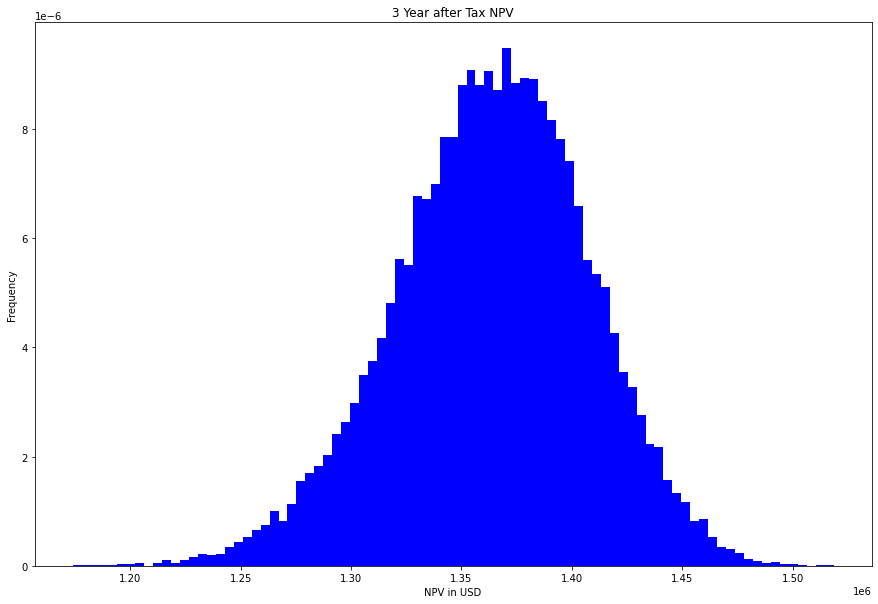

In [0]:
npv_3_after, irr_3_after = get_results_plot(npv_irr_after_tax_3, "3", before_tax=False)

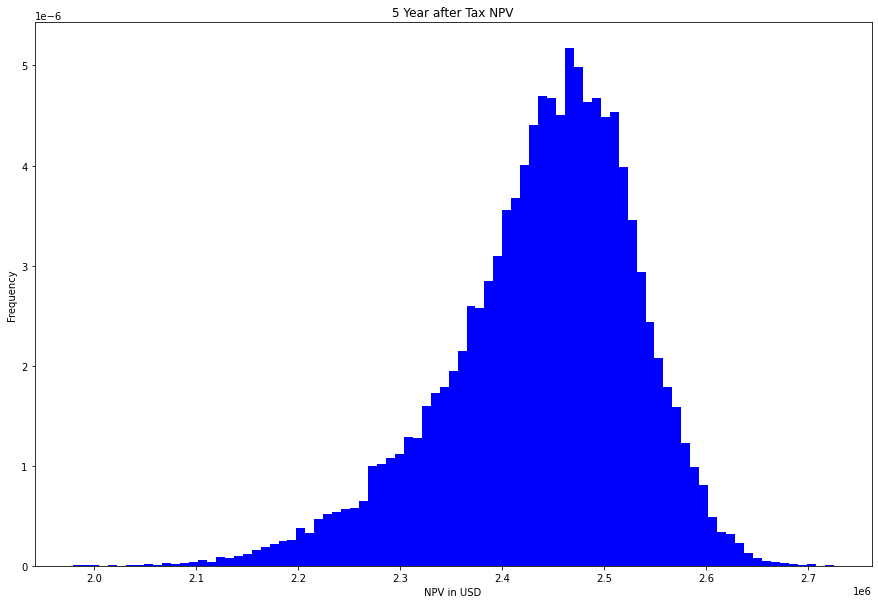

In [0]:
npv_5_after, irr_5_after = get_results_plot(npv_irr_after_tax_5, "5", before_tax=False)

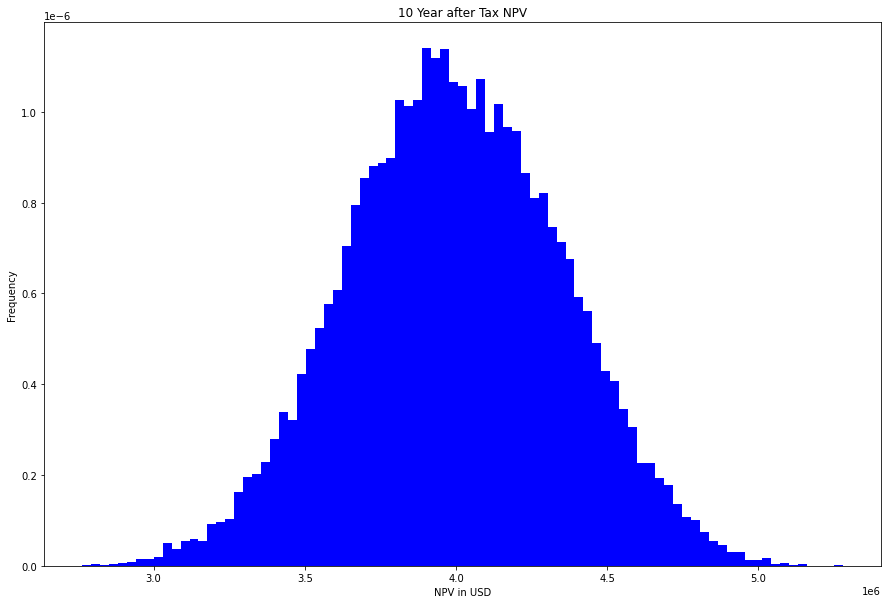

In [0]:
npv_10_after, irr_10_after = get_results_plot(npv_irr_after_tax_10, "10", before_tax=False)

In [0]:
print(np.mean(npv_10_after))
print(np.median(npv_10_after))
print(np.min(npv_10_after))
print(np.max(npv_10_after))

3994645.2904628003
3989738.51
2763651.04
5279937.16

In [0]:
print(np.mean(npv_5_after))
print(np.median(npv_5_after))
print(np.min(npv_5_after))
print(np.max(npv_5_after))

2439443.2575239995
2451311.4299999997
1978685.1
2725232.76

In [0]:
print(np.mean(npv_3_after))
print(np.median(npv_3_after))
print(np.min(npv_3_after))
print(np.max(npv_3_after))

1363641.3338116
1365366.495
1173857.59
1518522.68